In [3]:
# -*- coding: utf-8 -*-
"""
Created on Tue Oct 22 15:50:49 2019

@author: Jorge Melo & Xavier Pinho
"""
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew 
from scipy import stats
import datetime
import ast
import json
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
import os

In [4]:
# Data Importation
df_train = pd.read_csv("C://Users//XAVIER//Desktop//5ano_1Semestre//IA//project//tmdb-box-office-prediction//train.csv")
df_test = pd.read_csv("C://Users//XAVIER//Desktop//5ano_1Semestre//IA//project//tmdb-box-office-prediction//test.csv")

# Data index
print(df_train.index)
print(df_test.index)

RangeIndex(start=0, stop=3000, step=1)
RangeIndex(start=0, stop=4398, step=1)


In [3]:
# Concatenate train and test
df_all = pd.concat([df_train, df_test], sort=False).reset_index()

# Check for null values
print(df_all.isnull().sum())

index                       0
id                          0
belongs_to_collection    5917
budget                      0
genres                     23
homepage                 5032
imdb_id                     0
original_language           0
original_title              0
overview                   22
popularity                  0
poster_path                 2
production_companies      414
production_countries      157
release_date                1
runtime                     6
spoken_languages           62
status                      2
tagline                  1460
title                       3
Keywords                  669
cast                       26
crew                       38
revenue                  4398
dtype: int64


In [4]:
#Drop elements without poster
df_train.drop(df_train.loc[df_train["id"] == 2303].index, inplace=True)

In [5]:
target_col_name = "revenue"
sc = StandardScaler()

In [6]:
def visualize_distribution(y):
    
    plt.figure(figsize=(15, 8))
    sns.distplot(y,fit=norm)
    mu,sigma=norm.fit(y)
    plt.legend(["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})".format(mu,sigma)])
    plt.title("Distribution")
    plt.ylabel("Frequency")
    plt.show()
    
    
def visualize_probplot(y):
    plt.figure(figsize=(15, 8))
    stats.probplot(y,plot=plt)
    plt.show()

In [7]:
def showJointPlot(df, col_name):
    

    if not col_name in df.columns:
        print(col_name + " is not inside columns")
        return

    print("***[" + col_name + "]***")
    print("describe : ")
    print(df[col_name].describe())
    print("skew : ")
    print(df[col_name].skew())

    #correlation
    corrmat = df.corr()
    num_of_col = len(corrmat.columns)
    cols = corrmat.nlargest(num_of_col, col_name)[col_name]
    print("*****[ corr : " + col_name + " ]*****")
    print(cols)
    print("*****[" + col_name + "]*****")
    print("\n")


    visualize_distribution(df[col_name].dropna())
    visualize_probplot(df[col_name].dropna())


    if col_name != target_col_name and target_col_name in df.columns:
        plt.figure(figsize=(15, 8))
        sns.jointplot(col_name, target_col_name, df)

    print("******\n")
    return 

In [8]:
def showValueCount(df, col_name):

    if not col_name in df.columns:
        print(col_name, " is not inside columns")
        return

    print("***[" + col_name + "]***")
    print("describe :")
    print(df[col_name].describe())

    df_value = df[col_name].value_counts(dropna=False)
    print("value_counts :")
    print(df_value)

    plt.figure(figsize=(15,8))
    sns.barplot(df_value.index, df_value.values, alpha=0.8)
    plt.ylabel('Number of each element', fontsize=12)
    plt.xlabel(col_name, fontsize=12)
    plt.xticks(rotation=90, size='small')
    plt.show()


    if col_name != target_col_name and target_col_name in df.columns:
        plt.figure(figsize=(15, 8))
        plt.xticks(rotation=90, size='small')
        sns.boxplot(x=df[col_name], y =df[target_col_name])
        plt.show()

    print("******\n")
    return 

In [9]:
def countAndExpandFromDictToColumns(df, expanded_col_name, _val_name):
    
    df[expanded_col_name] = df[expanded_col_name].dropna().map(lambda x : ast.literal_eval(x))
    
    def connectToString(x, prefix, val_name):

        str_names = []
        for val in x:

            str_names.append(prefix + "_" + val[val_name])

        return ",".join(str_names)


    df[expanded_col_name] = df[expanded_col_name].dropna().map(lambda x : connectToString(x, prefix=expanded_col_name, val_name=_val_name))
    #print(df[expanded_col_name].head())
    df_tmp = df[expanded_col_name].dropna().str.get_dummies(sep=',')
    #print(df_tmp.info())
    df = pd.concat([df, df_tmp], axis=1, sort=False)

    df.drop(expanded_col_name, axis=1, inplace=True)


    return df

In [10]:
def countFromDict(df, count_col_name, _val_name=None):
    
    count_dic = {}

    def countFromDf(x):
        for val in ast.literal_eval(x):

            if _val_name != None:
                element_val = val[_val_name]
            else:
                element_val = json.dumps(val)
            if count_dic.get(element_val, 0) == 0:
                count_dic[element_val] = 1
            else:
                count_dic[element_val] = count_dic[element_val] + 1
        
        return x

    _ = df[count_col_name].dropna().map(lambda x : countFromDf(x))
    
    df_count = pd.DataFrame(list(count_dic.items()),columns=['key_name','num'])
    df_count.sort_values("num", ascending=False, inplace=True)

    return df_count

***[revenue]***
describe : 
count    3.000000e+03
mean     6.672585e+07
std      1.375323e+08
min      1.000000e+00
25%      2.379808e+06
50%      1.680707e+07
75%      6.891920e+07
max      1.519558e+09
Name: revenue, dtype: float64
skew : 
4.542285301660683
*****[ corr : revenue ]*****
revenue       1.000000
budget        0.752965
popularity    0.461460
runtime       0.216380
index         0.000610
id            0.000610
Name: revenue, dtype: float64
*****[revenue]*****




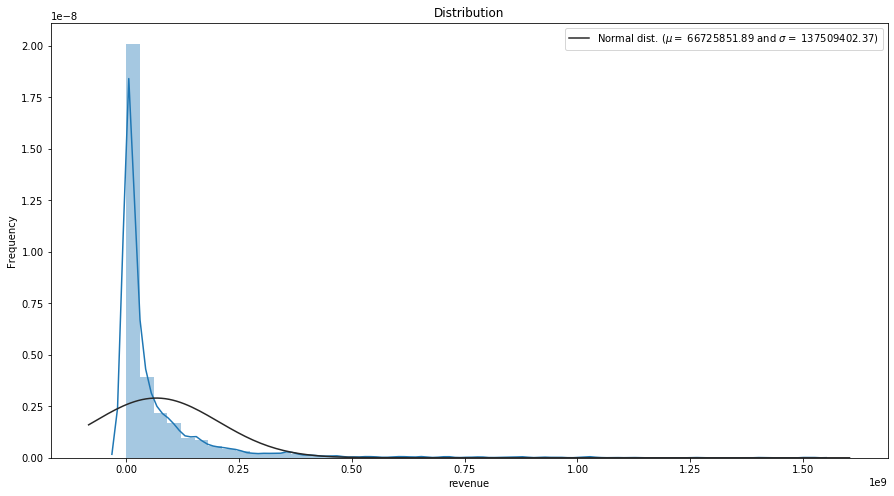

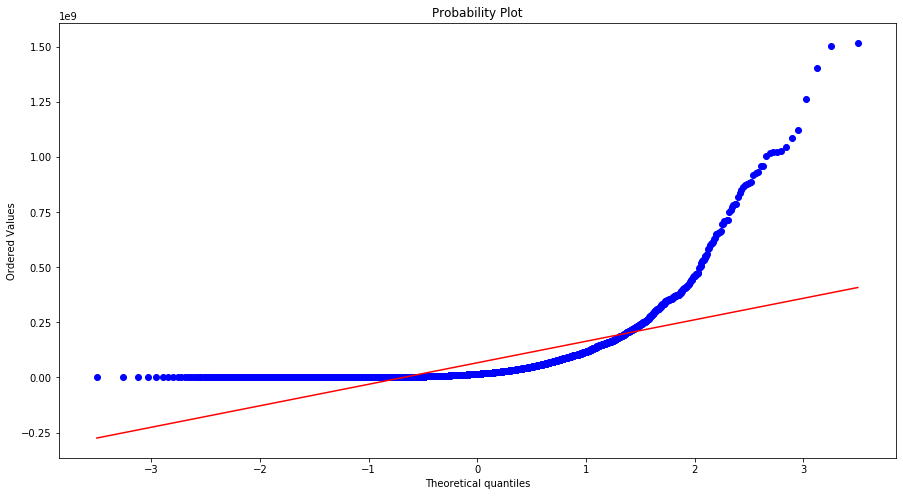

******



In [11]:
col_name = "revenue"

showJointPlot(df_all, col_name)

***[revenue]***
describe : 
count    3000.000000
mean       16.270743
std         2.659430
min         7.247081
25%        14.815338
50%        16.693831
75%        18.133508
max        25.297977
Name: revenue, dtype: float64
skew : 
-0.5581491025532077
*****[ corr : revenue ]*****
revenue       1.000000
budget        0.494160
popularity    0.281417
runtime       0.190119
index         0.003615
id            0.003615
Name: revenue, dtype: float64
*****[revenue]*****




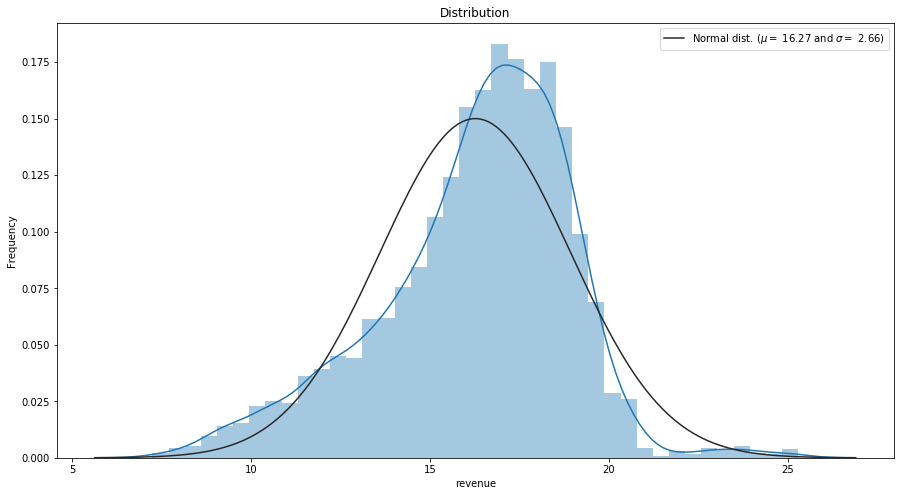

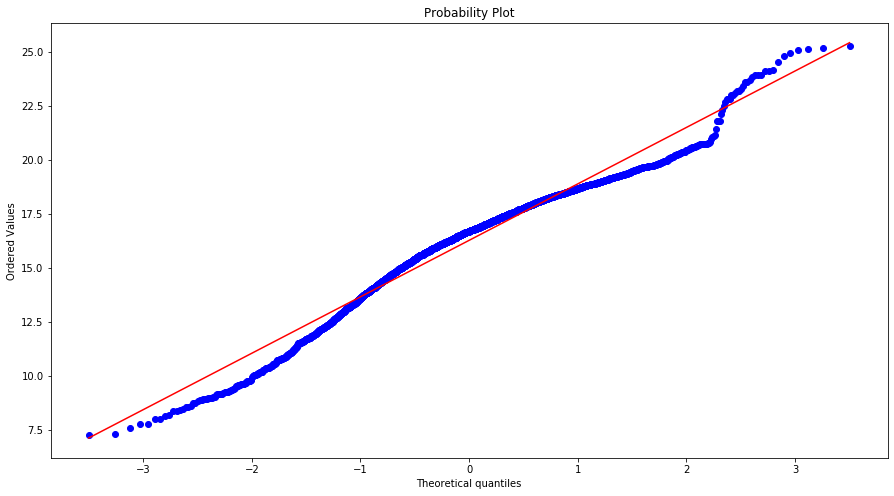

******



In [12]:
df_million_index = df_all.loc[df_all[col_name] < 100].index
df_thousand_index = df_all.loc[df_all[col_name] < 1000].index

df_all.loc[df_million_index, col_name] = df_all.loc[df_million_index, col_name].map(lambda x: x * 1000000)
df_all.loc[df_thousand_index, col_name] = df_all.loc[df_thousand_index, col_name].map(lambda x: x * 1000)

df_all[col_name] = np.log(df_all[col_name])
showJointPlot(df_all, col_name)

***[budget]***
describe : 
count    7.398000e+03
mean     2.260146e+07
std      3.694867e+07
min      0.000000e+00
25%      0.000000e+00
50%      7.500000e+06
75%      2.800000e+07
max      3.800000e+08
Name: budget, dtype: float64
skew : 
2.892441747364616
*****[ corr : budget ]*****
budget        1.000000
revenue       0.494160
popularity    0.340145
runtime       0.216251
index         0.005024
id            0.003845
Name: budget, dtype: float64
*****[budget]*****




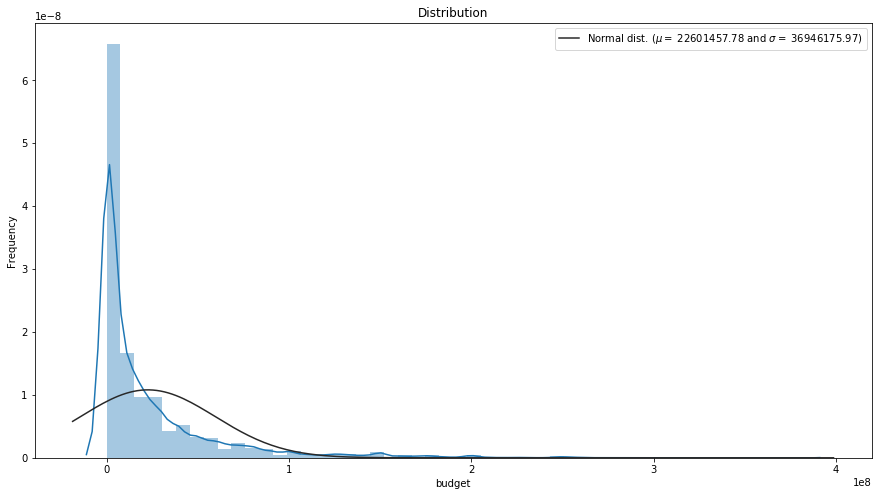

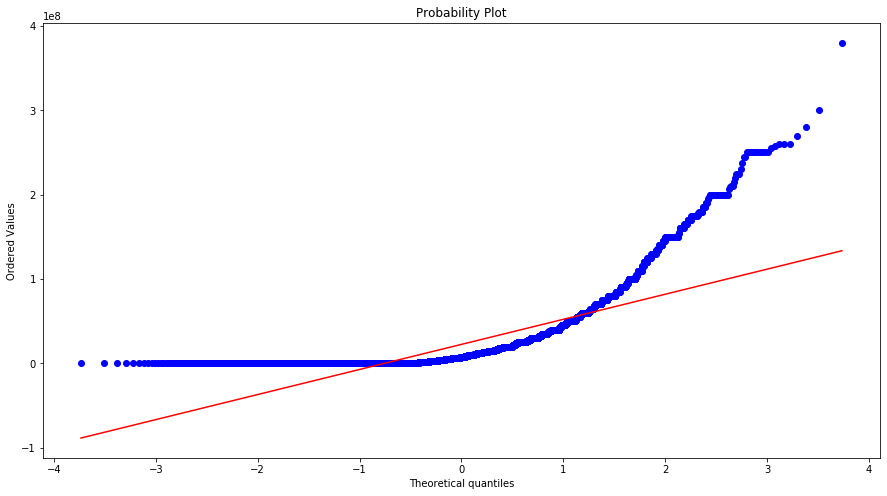

******



<Figure size 1080x576 with 0 Axes>

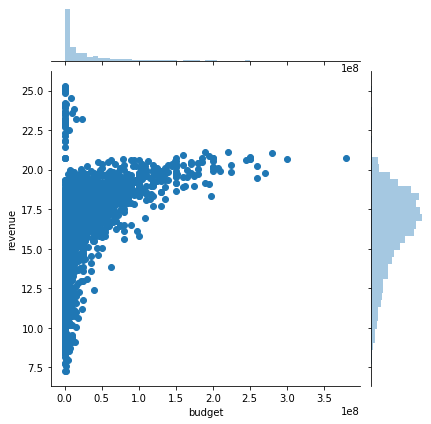

In [13]:
col_name = "budget"

showJointPlot(df_all, col_name)

***[budget]***
describe : 
count    7398.000000
mean       11.940726
std         7.465816
min         0.000000
25%         0.000000
50%        15.894952
75%        17.216708
max        25.255865
Name: budget, dtype: float64
skew : 
-0.8985439942565551
*****[ corr : budget ]*****
budget        1.000000
revenue       0.460516
popularity    0.207292
runtime       0.188844
index         0.002284
id           -0.001965
Name: budget, dtype: float64
*****[budget]*****




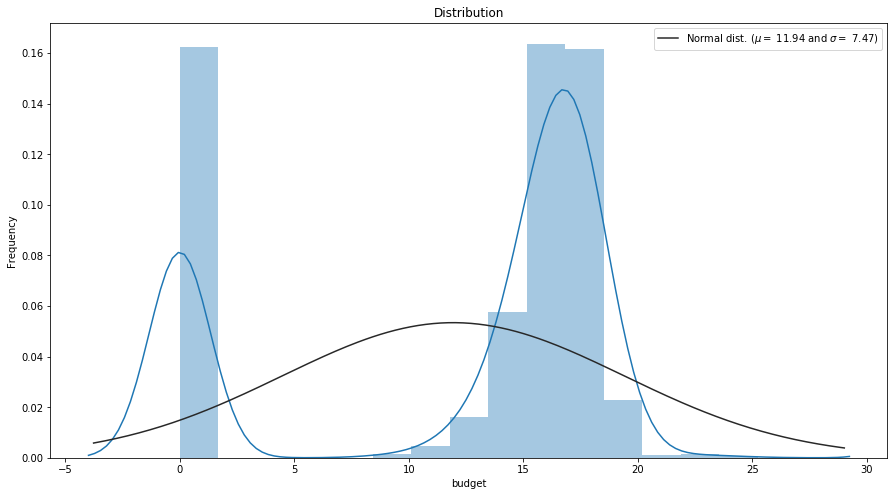

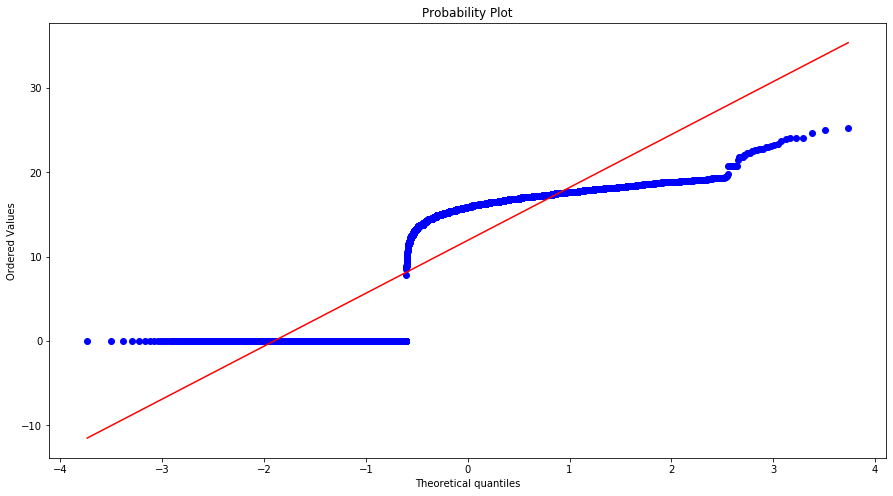

******



<Figure size 1080x576 with 0 Axes>

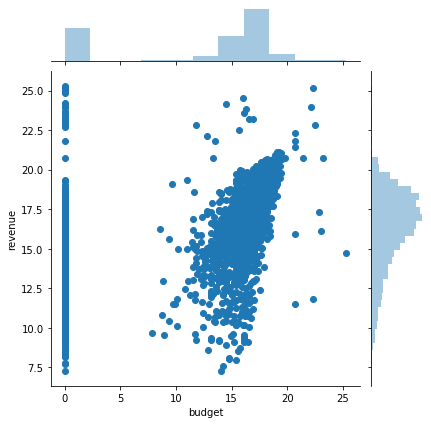

In [14]:
df_million_budget_index = df_all.loc[df_all[col_name] < 100].index
df_thousand_budget_index = df_all.loc[df_all[col_name] < 1000].index

df_all.loc[df_million_budget_index, col_name] = df_all.loc[df_million_budget_index, col_name].map(lambda x: x * 1000000)
df_all.loc[df_thousand_budget_index, col_name] = df_all.loc[df_thousand_budget_index, col_name].map(lambda x: x * 1000)

#df_all[col_name] = pd.Series(sc.fit_transform(df_all[col_name].values.reshape(-1, 1)).flatten())
df_all[col_name] = np.log1p(df_all[col_name])
showJointPlot(df_all, col_name)

In [15]:
#Release Date
col_name = "release_date"

print("\n**fillNanValues : " + col_name +  "***")
print(df_all.loc[df_all["release_date"].isnull() == True, ["title", "imdb_id", col_name]])
df_all.loc[df_all["imdb_id"] == "tt0210130", col_name] = "3/20/01"



**fillNanValues : release_date***
                           title    imdb_id release_date
3828  Jails, Hospitals & Hip-Hop  tt0210130          NaN


In [16]:
df_all[col_name + "_year"] = df_all[col_name].map(lambda x: int(x.split("/")[2]))
df_all[col_name + "_month"] = df_all[col_name].map(lambda x: int(x.split("/")[0]))
df_all[col_name + "_day"] = df_all[col_name].map(lambda x: int(x.split("/")[1]))


#we assume that release years are between 1900 and 2017
df_all.loc[(df_all[col_name + "_year"] < 18), col_name + "_year"] += 2000
df_all.loc[(df_all[col_name + "_year"] >= 18) & (df_all[col_name + "_year"] < 100), col_name + "_year"] += 1900

df_all[col_name] = df_all.apply(lambda x: datetime.datetime(x[col_name + "_year"], x[col_name + "_month"], x[col_name + "_day"]), axis=1)

df_all[col_name + "_month"] = df_all[col_name + "_month"].replace({1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun", 7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"})

dow = ["Mon","Tue","Wed","Thr","Fri","Sat","Sun"]
df_all[col_name + "_dayofweek"] = df_all[col_name].map(lambda x: dow[x.weekday()])

df_all[col_name + "_week"]= pd.Series(len(df_all[col_name]), index=df_all.index)
df_all.loc[df_all[col_name + "_day"] <= 7, col_name + "_week"] = "w1"
df_all.loc[(df_all[col_name + "_day"] > 7) & (df_all[col_name + "_day"] <= 14), col_name + "_week"] = "w2"
df_all.loc[(df_all[col_name + "_day"] > 14) & (df_all[col_name + "_day"] <= 21), col_name + "_week"] = "w3"
df_all.loc[(df_all[col_name + "_day"] > 21) & (df_all[col_name + "_day"] <= 28), col_name + "_week"] = "w4"
df_all.loc[(df_all[col_name + "_day"] > 28), col_name + "_week"] = "w5"

df_all[col_name + "_MonthWeek"] = df_all[col_name + "_month"] + df_all[col_name + "_week"]

df_all.drop(col_name + "_month", inplace=True, axis=1)
df_all.drop(col_name + "_week", inplace=True, axis=1)
df_all.drop(col_name + "_day", inplace=True, axis=1)
df_all.drop(col_name, inplace=True, axis=1)

***[release_date_year]***
describe :
count    7398.000000
mean     1999.677210
std        15.369115
min      1918.000000
25%      1992.000000
50%      2004.000000
75%      2011.000000
max      2017.000000
Name: release_date_year, dtype: float64
value_counts :
2013    335
2014    320
2015    312
2011    311
2010    306
       ... 
1922      1
1918      1
1921      1
1929      1
1924      1
Name: release_date_year, Length: 98, dtype: int64


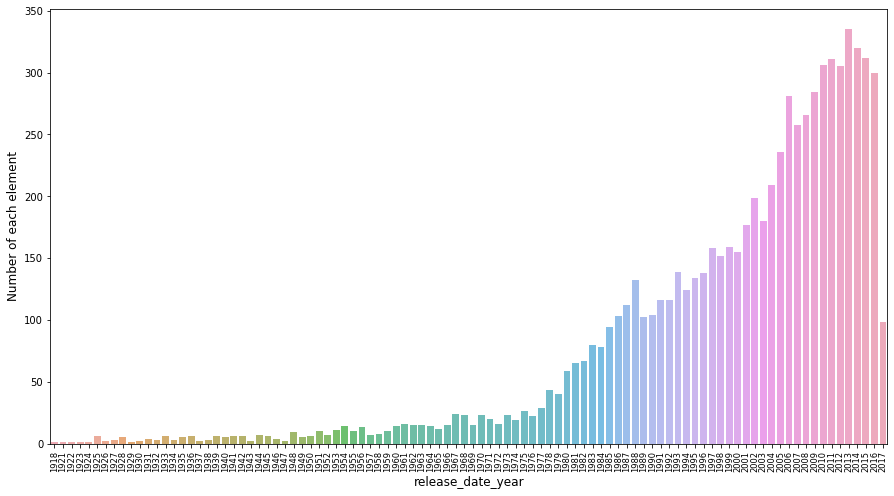

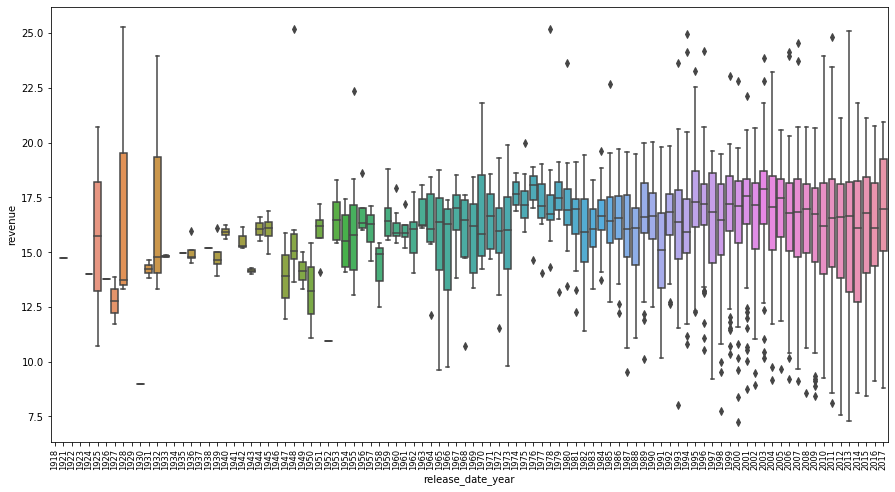

******

***[release_date_dayofweek]***
describe :
count     7398
unique       7
top        Fri
freq      3244
Name: release_date_dayofweek, dtype: object
value_counts :
Fri    3244
Thr    1436
Wed    1234
Tue     470
Sat     400
Mon     317
Sun     297
Name: release_date_dayofweek, dtype: int64


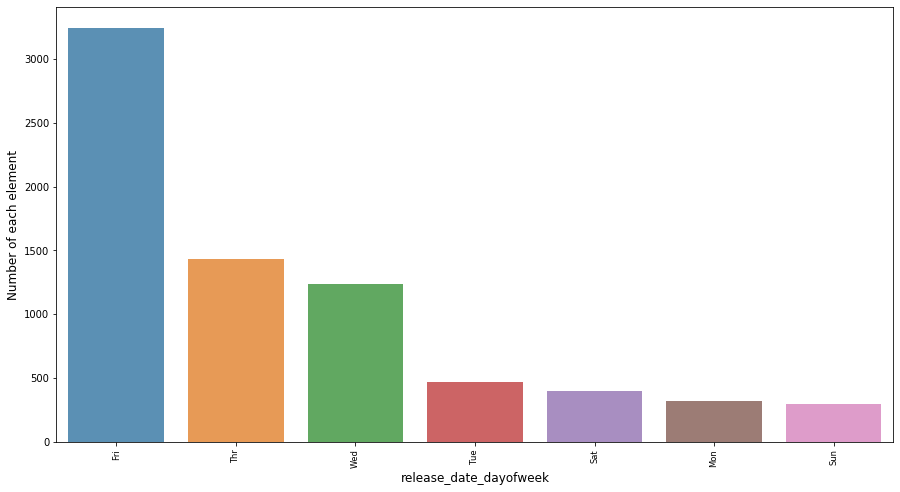

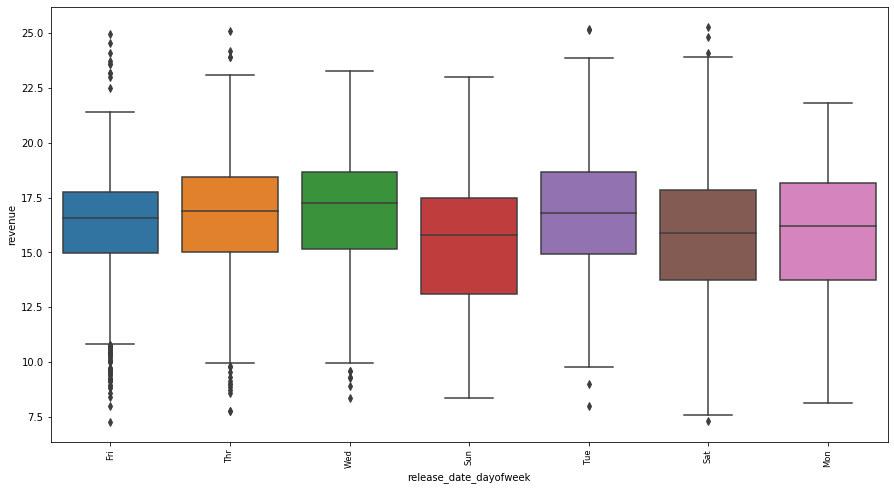

******

***[release_date_MonthWeek]***
describe :
count      7398
unique       60
top       Sepw2
freq        304
Name: release_date_MonthWeek, dtype: object
value_counts :
Sepw2    304
Sepw1    228
Decw3    205
Decw4    182
Octw1    178
Octw3    177
Mayw3    173
Decw2    172
Sepw3    170
Octw2    164
Augw1    160
Febw2    157
Augw2    157
Sepw4    152
Febw1    151
Junw4    149
Junw3    143
Augw4    142
Augw3    139
Junw1    138
Marw2    137
Janw3    135
Aprw1    135
Aprw2    134
Novw2    134
Marw3    134
Novw3    133
Octw4    133
Novw4    132
Julw4    131
Aprw4    130
Julw1    130
Mayw4    130
Marw1    129
Novw1    126
Junw2    126
Julw3    125
Aprw3    125
Julw2    124
Mayw2    124
Marw4    116
Janw4    116
Mayw1    115
Febw3    114
Janw1    114
Decw1    113
Febw4     93
Janw2     90
Augw5     60
Julw5     57
Janw5     57
Sepw5     50
Marw5     49
Octw5     45
Mayw5     43
Junw5     40
Aprw5     34
Decw5     24
Novw5     16
Febw5      4
Name: release_date_MonthWeek, dtype: int64


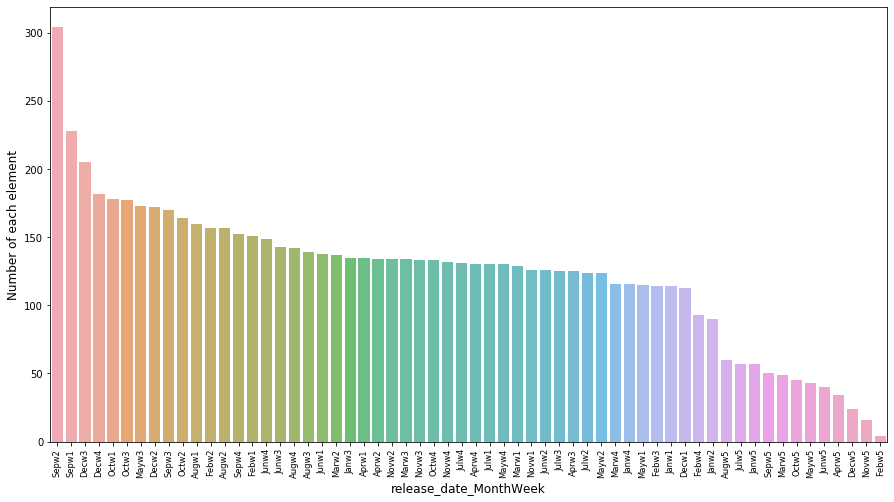

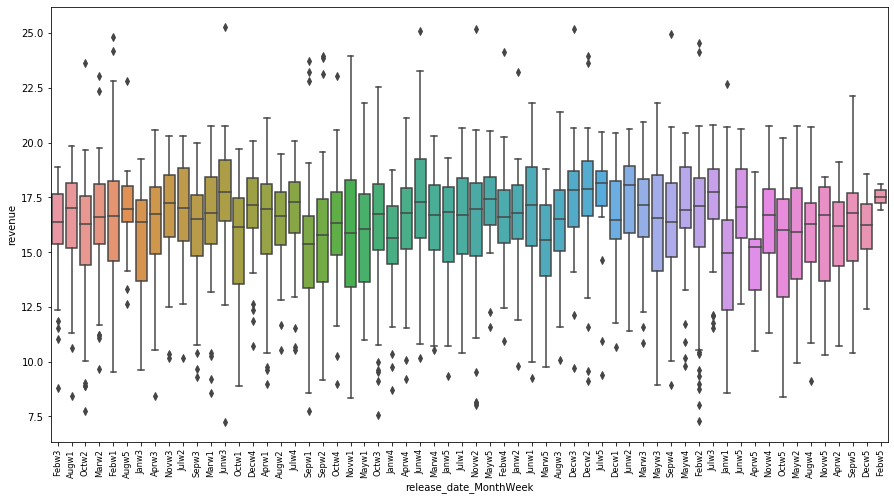

******



In [17]:
showValueCount(df_all, col_name + "_year")
showValueCount(df_all, col_name + "_dayofweek")
showValueCount(df_all, col_name + "_MonthWeek")

***[inCollection]***
describe :
count    7398.000000
mean        0.200189
std         0.400169
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: inCollection, dtype: float64
value_counts :
0    5917
1    1481
Name: inCollection, dtype: int64


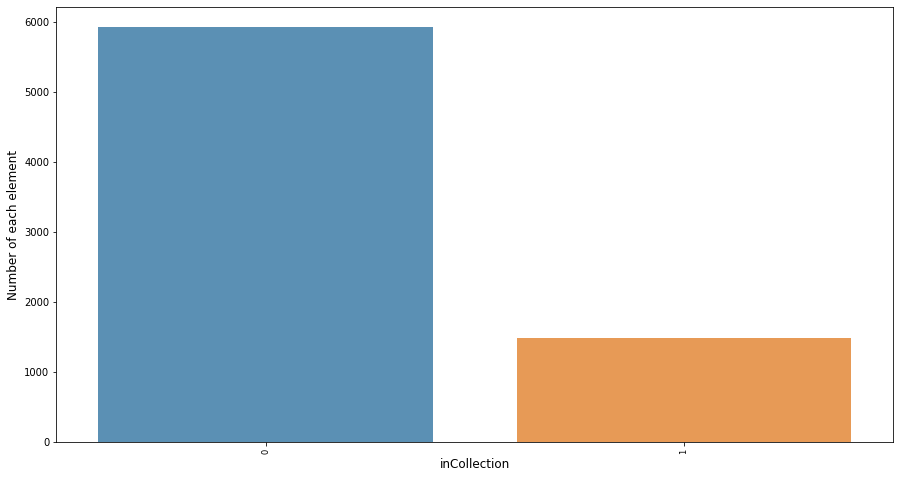

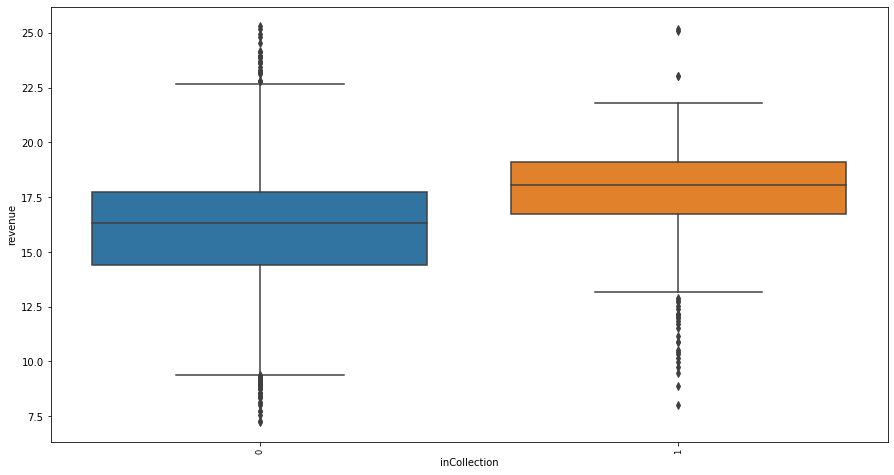

******



In [18]:
col_name = "belongs_to_collection"

df_all["inCollection"] = 0
df_all.loc[df_all[col_name].isnull() == False, "inCollection"] = 1

showValueCount(df_all, "inCollection")
df_all.drop(col_name, inplace=True, axis=1)

In [19]:
col_name = "genres"

print(df_all.loc[df_all[col_name].isnull(), ["imdb_id", "title", col_name]])
print("\n**fillNanValues : " + col_name +  "***")

#fill from IMDB
df_all.loc[df_all["imdb_id"] == "tt0349159", col_name] = "[{'id': 12, 'name': 'Adventure'}]"
df_all.loc[df_all["imdb_id"] == "tt0261755", col_name] = "[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name': 'Comedy'}]"
df_all.loc[df_all["imdb_id"] == "tt0110289", col_name] = "[{'id': 35, 'name': 'Comedy'}]"
df_all.loc[df_all["imdb_id"] == "tt0352622", col_name] = "[{'id': 10749, 'name': 'Romance'}, {'id': 18, 'name': 'Drama'}]"
df_all.loc[df_all["imdb_id"] == "tt0984177", col_name] = "[{'id': 28, 'name': 'Action'}, {'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]"
df_all.loc[df_all["imdb_id"] == "tt0833448", col_name] = "[{'id': 53, 'name': 'Thriller'}]"
df_all.loc[df_all["imdb_id"] == "tt1766044", col_name] = "[{'id': 18, 'name': 'Drama'}, {'id': 14, 'name': 'Fantasy'}, {'id': 9648, 'name': 'Mystery'}]"
df_all.loc[df_all["imdb_id"] == "tt0090904", col_name] = "[{'id': 28, 'name': 'Action'}, {'id': 80, 'name': 'Crime'}, {'id': 53, 'name': 'Thriller'}]"
df_all.loc[df_all["imdb_id"] == "tt0086405", col_name] = "[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]"
df_all.loc[df_all["imdb_id"] == "tt0044177", col_name] = "[{'id': 12, 'name': 'Adventure'}, {'id': 99999999, 'name': 'Biography'}, {'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]"
df_all.loc[df_all["imdb_id"] == "tt0108234", col_name] = "[{'id': 28, 'name': 'Action'}, {'id': 80, 'name': 'Crime'}, {'id': 18, 'name': 'Drama'}, {'id': 53, 'name': 'Thriller'}]"
df_all.loc[df_all["imdb_id"] == "tt1572916", col_name] = "[{'id': 18, 'name': 'Drama'}]"
df_all.loc[df_all["imdb_id"] == "tt1569465", col_name] = "[{'id': 35, 'name': 'Comedy'}]"
df_all.loc[df_all["imdb_id"] == "tt0405699", col_name] = "[{'id': 28, 'name': 'Action'}, {'id': 80, 'name': 'Crime'}]"
df_all.loc[df_all["imdb_id"] == "tt0461892", col_name] = "[{'id': 28, 'name': 'Action'}, {'id': 18, 'name': 'Drama'}]"
df_all.loc[df_all["imdb_id"] == "tt3121604", col_name] = "[{'id': 18, 'name': 'Drama'}]"
df_all.loc[df_all["imdb_id"] == "tt1164092", col_name] = "[{'id': 99, 'name': 'Documentary'}, {'id': 99999999, 'name': 'Biography'}, {'id': 10751, 'name': 'Family'}]"
df_all.loc[df_all["imdb_id"] == "tt0250282", col_name] = "[{'id': 35, 'name': 'Comedy'}]"
df_all.loc[df_all["imdb_id"] == "tt1620464", col_name] = "[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'name': 'Crime'}, {'id': 9648, 'name': 'Mystery'}]"
df_all.loc[df_all["imdb_id"] == "tt0073317", col_name] = "[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'name': 'Crime'}, {'id': 18, 'name': 'Drama'}]"
df_all.loc[df_all["imdb_id"] == "tt0361498", col_name] = "[{'id': 35, 'name': 'Comedy'}]"
df_all.loc[df_all["imdb_id"] == "tt0361596", col_name] = "[{'id': 99, 'name': 'Documentary'}, {'id': 18, 'name': 'Drama'}, {'id': 10752, 'name': 'War'}]"
df_all.loc[df_all["imdb_id"] == "tt2192844", col_name] = "[{'id': 18, 'name': 'Drama'}]"

        imdb_id                                            title genres
470   tt0349159  The Book of Mormon Movie, Volume 1: The Journey    NaN
1622  tt0261755                                          Jackpot    NaN
1814  tt0110289                                Ryaba, My Chicken    NaN
1819  tt0352622                                Sky. Plane. Girl.    NaN
2423  tt0984177                                        Amarkalam    NaN
2686  tt0833448                                             Lift    NaN
2900  tt1766044                           Rita's Last Fairy Tale    NaN
3073  tt0090904                                Dangerously Close    NaN
3793  tt0086405                                   Table For Five    NaN
3910  tt0044177                                        Valentino    NaN
4221  tt0108234                                    Street Knight    NaN
4442  tt1572916                                           My Son    NaN
4615  tt1569465                       Nasha Russia: Yaytsa sudby

***[genres_len]***
describe :
count    7398.000000
mean        2.494052
std         1.089433
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         5.000000
Name: genres_len, dtype: float64
value_counts :
2    2384
3    2215
1    1497
4     969
5     333
Name: genres_len, dtype: int64


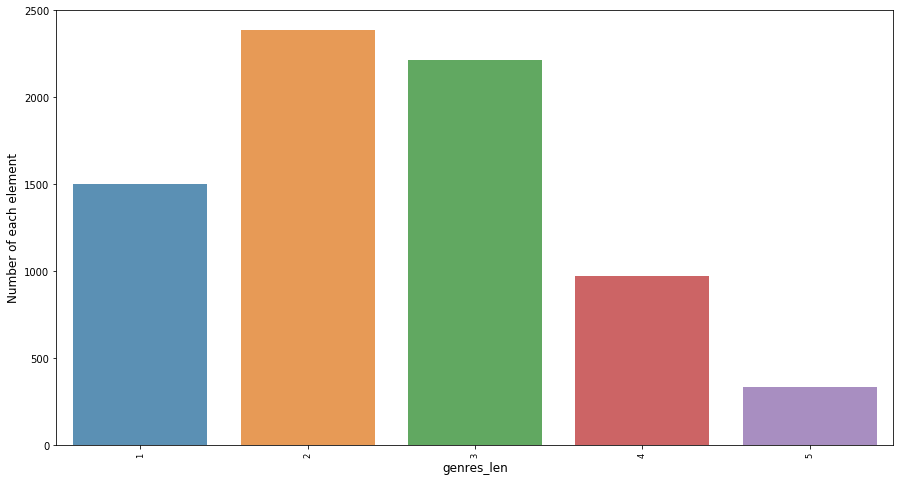

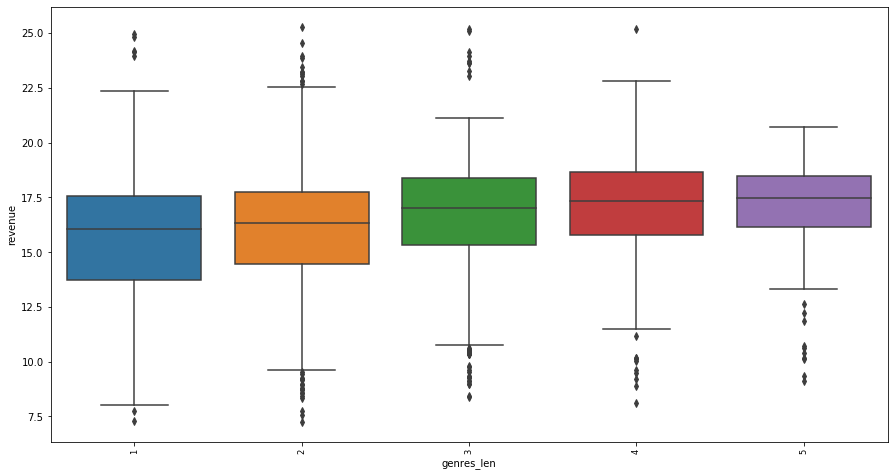

******



In [20]:
df_all[col_name + "_len"] = df_all[col_name].map(lambda x: len(ast.literal_eval(x)) if pd.isnull(x) == False else 0)
df_all.loc[df_all[col_name + "_len"] > 5, col_name + "_len"] = 5
showValueCount(df_all, col_name + "_len")

In [21]:
df_all = countAndExpandFromDictToColumns(df_all, col_name, "name")
print(df_all.shape)

(7398, 47)



**fillNanValues : runtime***
                             title    imdb_id  release_date  runtime
1335                       Королёв  tt1107828           NaN      NaN
2302                 Happy Weekend  tt0116485           NaN      NaN
3243     La caliente niña Julietta  tt0082131           NaN      NaN
4489   Pancho, el perro millonario  tt3132094           NaN      NaN
4632       Nunca en horas de clase  tt0078010           NaN      NaN
6817  Miesten välisiä keskusteluja  tt2192844           NaN      NaN
***[runtime]***
describe : 
count    7392.000000
mean      107.717262
std        21.480040
min         0.000000
25%        94.000000
50%       104.000000
75%       118.000000
max       338.000000
Name: runtime, dtype: float64
skew : 
1.1189042635711173
*****[ corr : runtime ]*****
runtime                   1.000000
genres_Drama              0.258204
genres_History            0.236675
revenue                   0.190119
budget                    0.188844
genres_War                0.16

C:\Users\XAVIER\Anaconda3\Lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


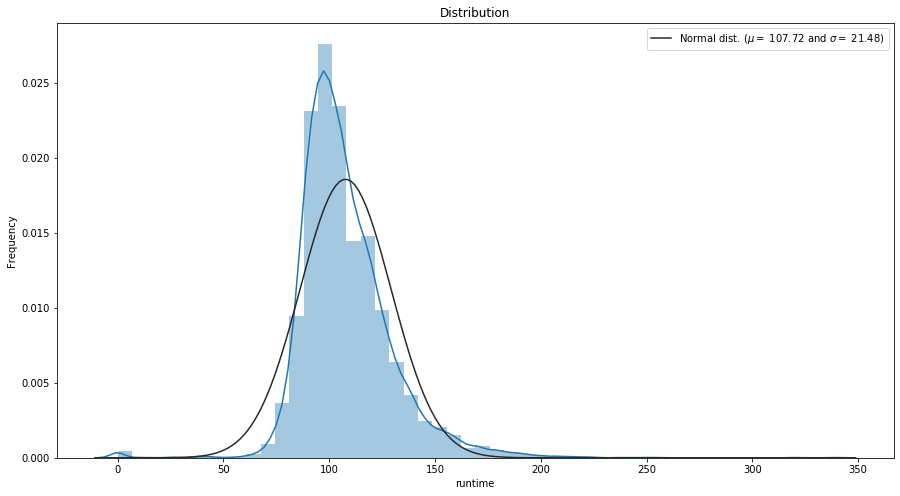

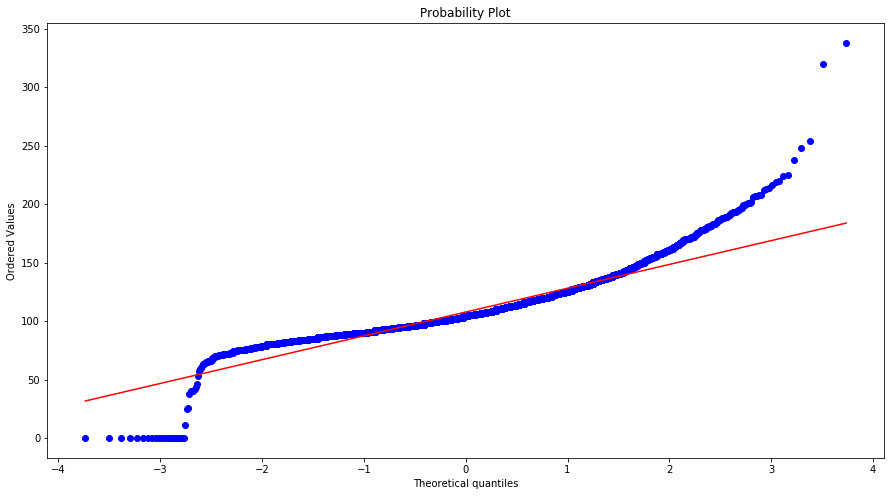

******



<Figure size 1080x576 with 0 Axes>

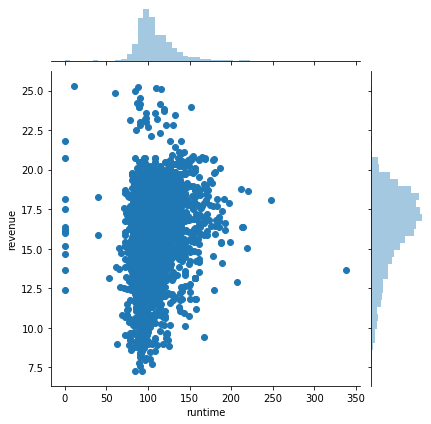

In [22]:
col_name = "runtime"

print("\n**fillNanValues : " + col_name +  "***")
print(df_all.loc[df_all["runtime"].isnull() == True, ["title", "imdb_id", "release_date", col_name]])

showJointPlot(df_all, col_name)

In [23]:
df_all.sort_values(col_name, ascending=False)[["title", col_name]]


,title,runtime
1211,Carlos,338.0
5710,Gangs of Wasseypur,320.0
4185,Gettysburg,254.0
1922,Cleopatra,248.0
6335,Gone with the Wind,238.0
...,...,...
2302,Happy Weekend,NaN
3243,La caliente niña Julietta,NaN
4489,"Pancho, el perro millonario",NaN
4632,Nunca en horas de clase,NaN


***[runtime]***
describe : 
count    7398.000000
mean        4.665564
std         0.180494
min         2.397895
25%         4.543295
50%         4.644391
75%         4.770685
max         5.823046
Name: runtime, dtype: float64
skew : 
0.1580440405898463
*****[ corr : runtime ]*****
runtime                   1.000000
genres_Drama              0.271394
genres_History            0.220716
revenue                   0.203769
budget                    0.196108
genres_War                0.162606
popularity                0.112888
genres_Action             0.094958
genres_Romance            0.077383
genres_Adventure          0.064251
genres_len                0.064194
genres_Western            0.055905
genres_Foreign            0.051762
genres_Crime              0.043422
genres_Mystery            0.035498
genres_Thriller           0.027580
genres_Music              0.026001
index                     0.008429
id                       -0.001649
genres_Biography         -0.010945
genres_TV Movie   

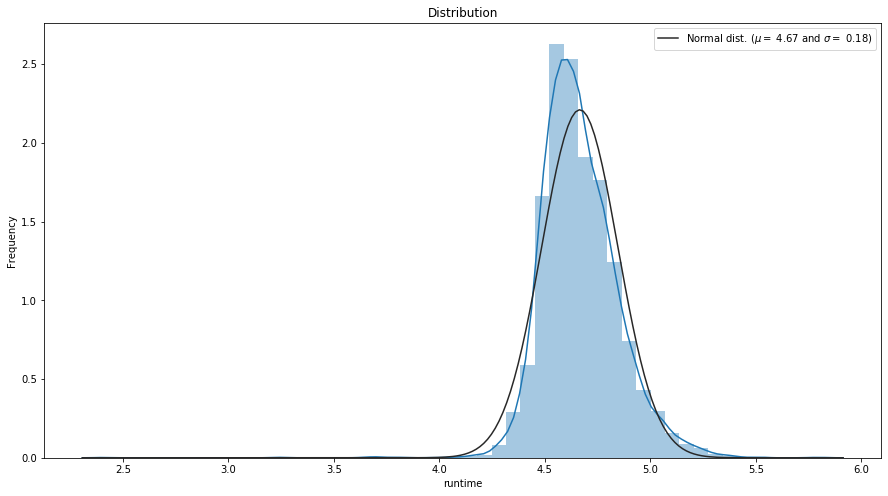

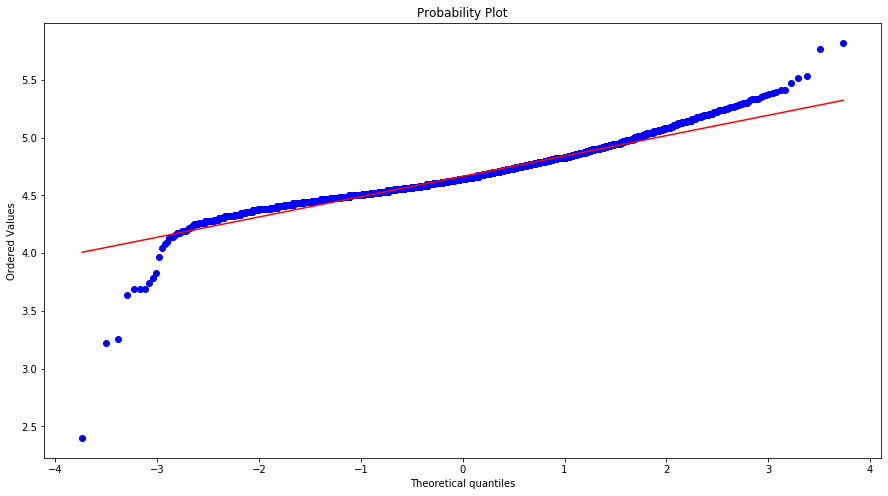

******



<Figure size 1080x576 with 0 Axes>

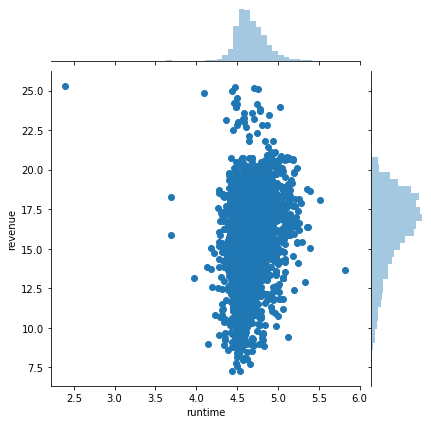

In [24]:
df_all.loc[df_all[col_name] == 0, col_name] = np.nan
df_all[col_name].fillna(df_all[col_name].median(), inplace=True)

#df_all[col_name] = pd.Series(sc.fit_transform(df_all[col_name].values.reshape(-1, 1)).flatten())
df_all[col_name] = np.log(df_all[col_name])
#df_all.drop(index=df_all.loc[df_all[col_name] < 2.4, ["title", col_name]].index, inplace=True)
#print(df_all.loc[df_all[col_name] < 2.4, ["title", col_name]])
showJointPlot(df_all, col_name)


In [25]:
#Spoken Languages
col_name = "spoken_languages"

print("\n**fillNanValues : " + col_name +  "***")

df_count_sLangugaes = countFromDict(df_all, col_name)
df_count_sLangugaes["iso"] = df_count_sLangugaes["key_name"].map(lambda x: ast.literal_eval(x)["iso_639_1"])
#print(df_count_sLangugaes.head(len(df_count_sLangugaes)))


def returnStr(x):
    
    lis = df_count_sLangugaes.loc[df_count_sLangugaes["iso"] == x.original_language, "key_name"].values
    if len(lis) == 0:
        #print(x, lis)
        x.spoken_languages = np.nan
    else:
        str_dic = lis[0]
        x.spoken_languages =  str("[" + str_dic + "]")
    
    return x

df_all.loc[(df_all[col_name].isnull() == True), [col_name, "original_language"]] = df_all.loc[(df_all[col_name].isnull() == True), [col_name, "original_language"]].apply(lambda x: returnStr(x), axis=1)
df_all["lang_len"] = df_all[col_name].map(lambda x: len(ast.literal_eval(x)))

df_all = countAndExpandFromDictToColumns(df_all, col_name, "iso_639_1")
df_all.shape


**fillNanValues : spoken_languages***


(7398, 145)

0
***[isEnglish]***
describe :
count    7398.000000
mean        0.891863
std         0.310575
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: isEnglish, dtype: float64
value_counts :
1    6598
0     800
Name: isEnglish, dtype: int64


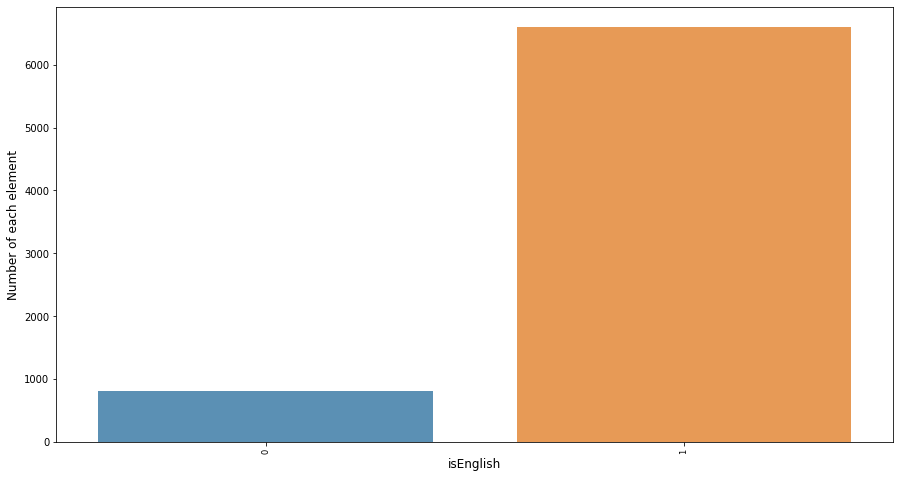

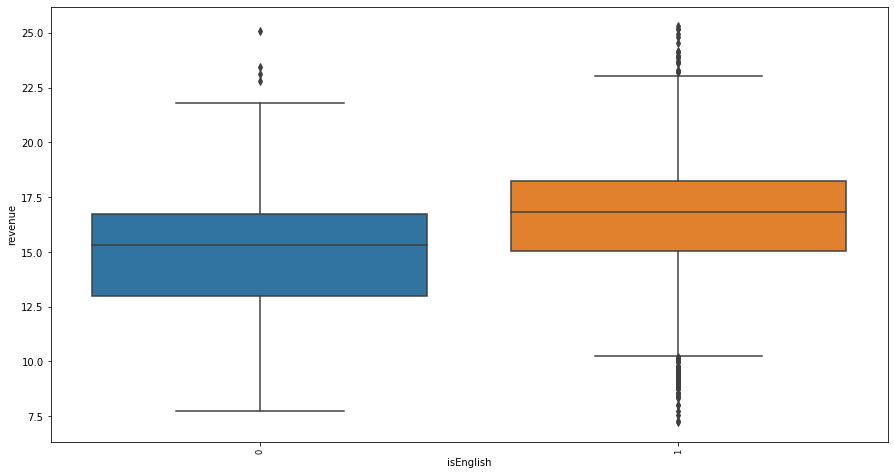

******



In [26]:
#Original Language
col_name = "original_language"

print(df_all[col_name].isnull().sum())

df_all["isEnglish"] = 0
df_all.loc[(df_all[col_name] == "en") | (df_all["spoken_languages_en"] == 1), "isEnglish"] = 1

showValueCount(df_all, "isEnglish")

In [27]:
col_name = "overview"
df_all[col_name].fillna(0, inplace=True)

***[popularity]***
describe : 
count    7398.000000
mean        8.514968
std        12.165794
min         0.000001
25%         3.933124
50%         7.435844
75%        10.920002
max       547.488298
Name: popularity, dtype: float64
skew : 
19.964376660906037
*****[ corr : popularity ]*****
popularity             1.000000
revenue                0.281417
budget                 0.207292
inCollection           0.161106
genres_Adventure       0.146820
                         ...   
spoken_languages_hi   -0.055950
genres_Romance        -0.062822
genres_Foreign        -0.066805
genres_Drama          -0.073401
genres_Documentary    -0.080565
Name: popularity, Length: 130, dtype: float64
*****[popularity]*****




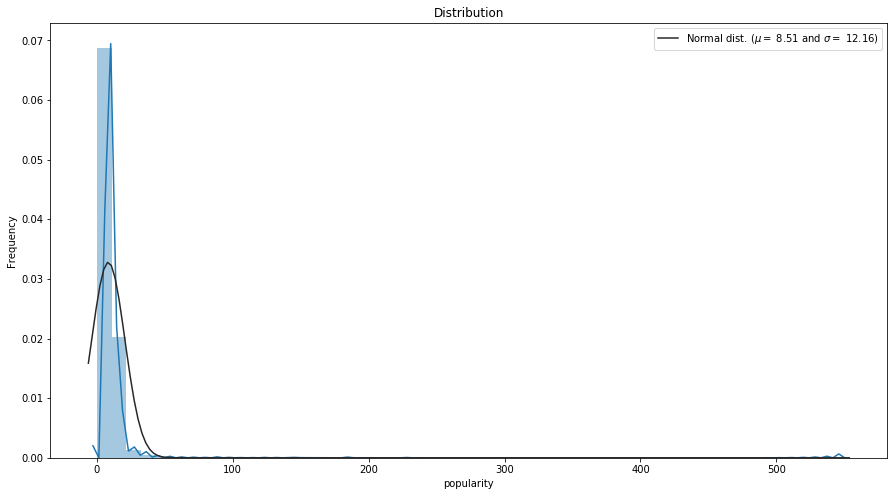

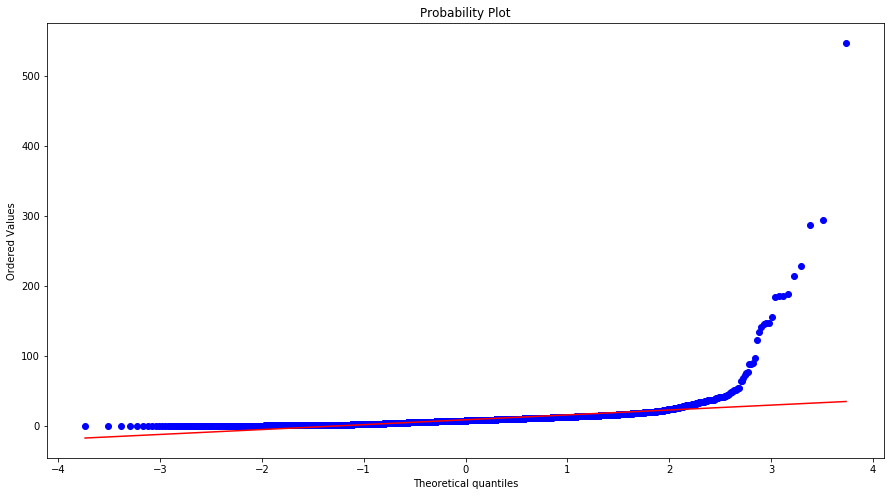

******



6380    547.488298
518     294.337037
684     287.253654
1695    228.032744
5977    213.849907
           ...    
741       0.000578
3243      0.000464
1683      0.000308
2556      0.000001
3830      0.000001
Name: popularity, Length: 7398, dtype: float64

<Figure size 1080x576 with 0 Axes>

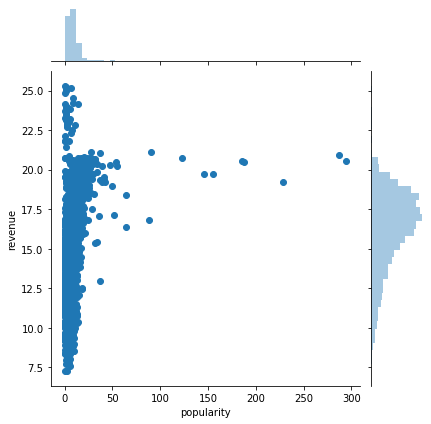

In [28]:
col_name = "popularity"

showJointPlot(df_all, col_name)
df_all[col_name].sort_values(ascending=False)

In [29]:
print(df_all.shape)
df_all[col_name + "_RANK"] = 2
df_all.loc[df_all[col_name] > 50, col_name + "_RANK"]= 3
df_all.loc[df_all[col_name] <= 3, col_name + "_RANK"] = 1

#df_all.drop(df_all.loc[(df_all["revenue"] < 10) & (df_all[col_name] > 25)].index, inplace=True)
df_all.loc[(df_all[col_name] < 0.0003), col_name] = 0.0003

#df_all[col_name] = pd.Series(sc.fit_transform(df_all[col_name].values.reshape(-1, 1)).flatten())
df_all[col_name] = np.log(df_all[col_name])

print(df_all.shape)
#showJointPlot(df_all, col_name)

(7398, 146)
(7398, 147)


In [30]:
#Crew
col_name = "crew"

df_all[col_name + "_num"] = df_all[col_name].map(lambda x: len(ast.literal_eval(x)) if pd.isnull(x) == False else np.nan)

***[crew_num]***
describe : 
count    7398.000000
mean        2.646587
std         1.089207
min         0.000000
25%         2.079442
50%         2.639057
75%         3.332205
max         5.267858
Name: crew_num, dtype: float64
skew : 
-0.18072605492463922
*****[ corr : crew_num ]*****
crew_num               1.000000
popularity             0.499598
popularity_RANK        0.431725
revenue                0.374113
budget                 0.349983
                         ...   
spoken_languages_hi   -0.079223
genres_Romance        -0.098045
genres_Foreign        -0.132327
genres_Comedy         -0.140095
genres_Documentary    -0.186846
Name: crew_num, Length: 132, dtype: float64
*****[crew_num]*****




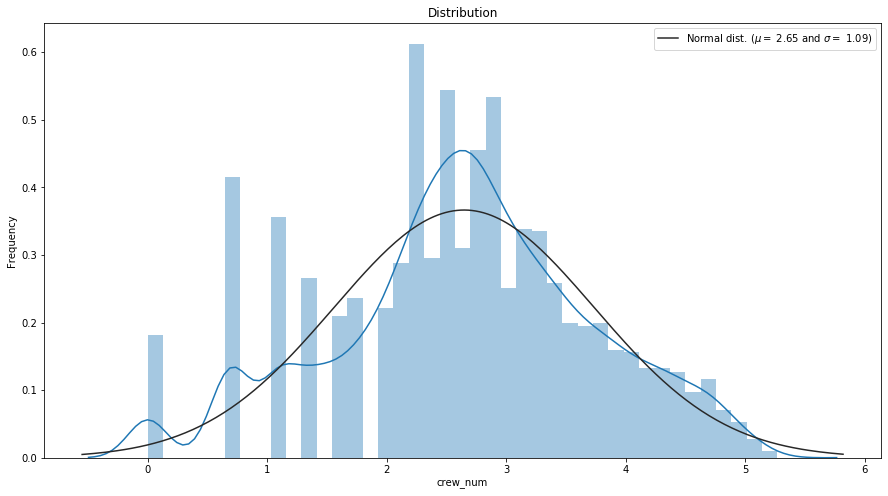

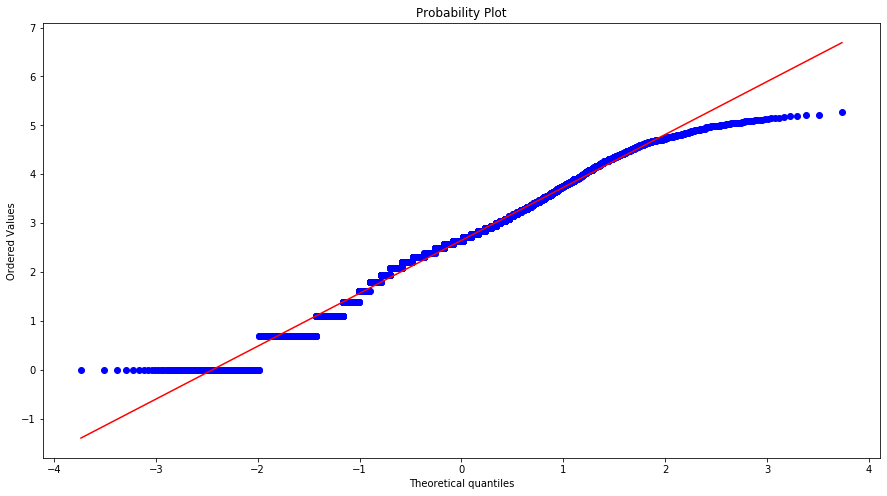

******



<Figure size 1080x576 with 0 Axes>

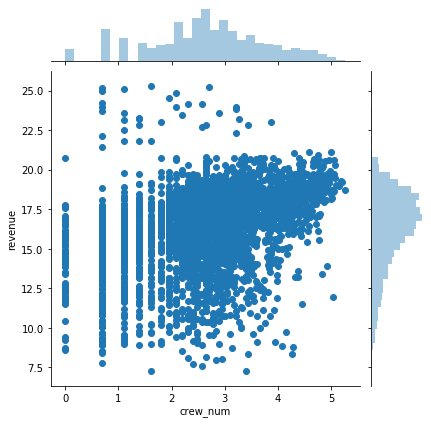

In [31]:
#fill na and 0 
df_all[col_name + "_num"].fillna(df_all[col_name + "_num"].median(), inplace=True)

#df_all[col_name + "_num"] = pd.Series(sc.fit_transform(df_all[col_name + "_num"].values.reshape(-1, 1)).flatten())
df_all[col_name + "_num"] = np.log(df_all[col_name + "_num"])

showJointPlot(df_all, col_name + "_num")


df_all.drop(col_name, axis=1, inplace=True)

In [32]:
#Cast
col_name = "cast"
        
df_all[col_name + "_num"] = df_all[col_name].map(lambda x: len(ast.literal_eval(x)) if pd.isnull(x) == False else np.nan)
df_all.loc[df_all[col_name + "_num"] == 0, col_name + "_num"] = np.nan

In [33]:
cast_dict = {}

def countName(x):
    cast_list = ast.literal_eval(x.cast)
    
    for each_cast in cast_list:
        cast_name = each_cast["name"]
        
        
        if cast_name not in cast_dict.keys():
            cast_dict[cast_name] = {"train":0, "test":0}
        
        which_data = "train"
        if x.id > 3000:
            which_data = "test"
        cast_dict[cast_name][which_data] += 1
    
    return x

df_all = df_all.apply(lambda x: countName(x) if pd.isnull(x.cast) == False else x, axis=1)

df_cast_count = pd.DataFrame(cast_dict).T
df_cast_count.reset_index(inplace=True)
df_cast_count.rename(columns={'index': 'name'}, inplace=True)
df_cast_count["total"] = df_cast_count["train"] + df_cast_count["test"]
df_cast_count.sort_values("total", inplace=True)
print(df_cast_count.shape)
print(df_cast_count.columns)
print(df_cast_count.index)
df_cast_count

(75944, 4)
Index(['name', 'train', 'test', 'total'], dtype='object')
Int64Index([37971, 50283, 50284, 50285, 50286, 50287, 50288, 50289, 50290,
            50291,
            ...
             5694,  3950,   159,  1436,  3523,  2497,   749,  2129,  7008,
              594],
           dtype='int64', length=75944)


,name,train,test,total
37971,Shirin Aghakashi,1,0,1
50283,Berta Ojea,0,1,1
50284,Adri√°n Lamana,0,1,1
50285,Daniel Esparza,0,1,1
50286,Javier Gonzalez Sanchez,0,1,1
...,...,...,...,...
2497,Liam Neeson,25,32,57
749,Morgan Freeman,27,34,61
2129,Bruce Willis,25,37,62
7008,Robert De Niro,30,41,71


***[cast_num]***
describe : 
count    7398.000000
mean        2.806690
std         0.690040
min         0.000000
25%         2.397895
50%         2.772589
75%         3.178054
max         5.105945
Name: cast_num, dtype: float64
skew : 
-0.0740553495993024
*****[ corr : cast_num ]*****
cast_num               1.000000
crew_num               0.483150
popularity             0.438980
popularity_RANK        0.373874
revenue                0.344023
                         ...   
spoken_languages_ko   -0.035865
genres_Animation      -0.047713
spoken_languages_hi   -0.096379
genres_Foreign        -0.112869
genres_Documentary    -0.243186
Name: cast_num, Length: 133, dtype: float64
*****[cast_num]*****




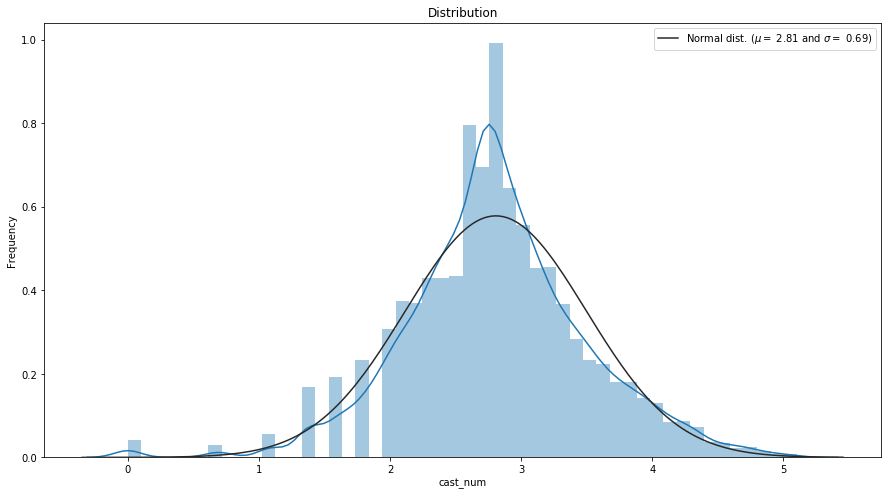

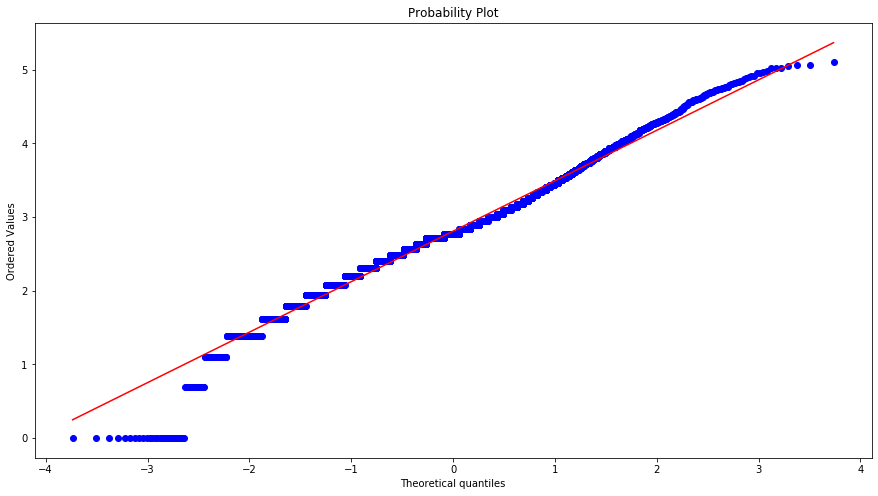

******



<Figure size 1080x576 with 0 Axes>

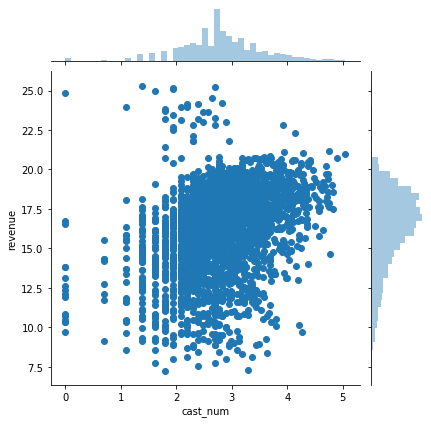

In [34]:
#fill na and 0 
df_all[col_name + "_num"].fillna( df_all[col_name + "_num"].median(), inplace=True)


#df_all[col_name + "_num"] = pd.Series(sc.fit_transform(df_all[col_name + "_num"].values.reshape(-1, 1)).flatten())
df_all[col_name + "_num"] = np.log(df_all[col_name + "_num"])

showJointPlot(df_all, col_name + "_num")

df_all.drop(col_name, axis=1, inplace=True)

In [35]:
#Drop keywords and overview
df_all.drop(["Keywords", "overview"], axis=1, inplace=True)


In [36]:
#Production
col_name = "production_countries"
        
print("\n**fillNanValues : " + col_name +  "***")

#df = fillNAN_productionC(df)
df_all["production_countries"].fillna("[{'iso_3166_1': 'US', 'name': 'United States of America'}]", inplace=True)
df_all = countAndExpandFromDictToColumns(df_all, col_name, "name")
df_all.shape


**fillNanValues : production_countries***


(7398, 242)

In [37]:
#homepage
col_name = "homepage"

df_all["hasHomepage"] = 1
df_all.loc[df_all[col_name].isnull() == True, "hasHomepage"] = 0

df_all.drop(col_name, axis=1, inplace=True)

In [38]:
df_all["budget_year_ratio"] = df_all["budget"] / df_all["release_date_year"]

drop_cols = ["imdb_id", "poster_path", "original_title", "tagline", "title", "status", "production_companies"]
df_all.drop(drop_cols, axis=1, inplace=True)

df_all = pd.get_dummies(df_all, drop_first=True, columns=['release_date_dayofweek'])

df_all = pd.get_dummies(df_all)
df_all.shape
df_all.to_csv('all_dataset.csv')

In [39]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import fbeta_score, make_scorer
import keras.backend as K
from keras.layers import Input, Dense, Activation, BatchNormalization, MaxPooling2D
from keras.models import Model
from keras.layers import concatenate
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping 
from keras.callbacks import LearningRateScheduler

In [40]:
train_idx = df_all[~df_all[target_col_name].isnull()].index.values
df_train = df_all.loc[train_idx].set_index('id')
df_train.drop(["index"], axis=1, inplace=True)

max_price = df_train["revenue"].max()
df_train["revenue"] = df_train["revenue"] / max_price
            
test_idx = df_all[df_all[target_col_name].isnull()].index.values
df_test = df_all.loc[test_idx].set_index('id')
df_test.drop([target_col_name, "index"], axis=1, inplace=True)

df_train_X = df_train.drop(target_col_name, axis=1)
df_train_y = df_train[target_col_name]

# Inspect shapes
print(df_train.shape)
print(df_test.shape)
print(df_train.columns)
print(df_test.columns)

scorer = make_scorer(mean_squared_error, greater_is_better = False)

(3000, 341)
(4398, 340)
Index(['budget', 'popularity', 'runtime', 'revenue', 'release_date_year',
       'inCollection', 'genres_len', 'genres_Action', 'genres_Adventure',
       'genres_Animation',
       ...
       'release_date_MonthWeek_Octw1', 'release_date_MonthWeek_Octw2',
       'release_date_MonthWeek_Octw3', 'release_date_MonthWeek_Octw4',
       'release_date_MonthWeek_Octw5', 'release_date_MonthWeek_Sepw1',
       'release_date_MonthWeek_Sepw2', 'release_date_MonthWeek_Sepw3',
       'release_date_MonthWeek_Sepw4', 'release_date_MonthWeek_Sepw5'],
      dtype='object', length=341)
Index(['budget', 'popularity', 'runtime', 'release_date_year', 'inCollection',
       'genres_len', 'genres_Action', 'genres_Adventure', 'genres_Animation',
       'genres_Biography',
       ...
       'release_date_MonthWeek_Octw1', 'release_date_MonthWeek_Octw2',
       'release_date_MonthWeek_Octw3', 'release_date_MonthWeek_Octw4',
       'release_date_MonthWeek_Octw5', 'release_date_MonthWeek_

In [41]:
indices = np.array(range(df_train.shape[0]))
valid_train_X, valid_test_X, valid_train_y, valid_test_y, indices_valid_train, indices_valid_test  = train_test_split(df_train_X, df_train_y, indices, test_size=0.2, shuffle=True, random_state=64)

print("valid_train_X", valid_train_X.shape)
print("valid_test_X", valid_test_X.shape)
print("valid_train_y", valid_train_y.shape)
print("valid_test_y", valid_test_y.shape)

valid_train_X (2400, 340)
valid_test_X (600, 340)
valid_train_y (2400,)
valid_test_y (600,)


In [42]:
def createNNmodel(_input_dim, regress=False):
    
    model = Sequential()
    model.add(Dense(120, input_dim=_input_dim, activation="relu"))
    model.add(Dense(80, activation="relu"))
    model.add(Dense(40, activation="relu"))
    model.add(Dense(20, activation="relu"))
    
    if regress:
        model.add(Dense(1, activation="linear"))
    
    return model

In [43]:
def createBoxOfficeNetModel(_input_dim_NN):
    
    model_NN = createNNmodel(_input_dim_NN)


    x = Dense(20, activation="relu")(model_NN.output)
    x = Dense(1, activation="linear")(x)
    
    
    model = Model(inputs=model_NN.input, outputs=x)
    
    return model

In [44]:
# my loss function for RMSE
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [45]:
def drawResultCurves(_history):
    # Plot the loss and accuracy curves for training and validation 

    fig, ax = plt.subplots(2,1) 
    ax[0].plot(_history.history['loss'], color='b', label="Training loss")
    ax[0].plot(_history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(_history.history['mean_squared_logarithmic_error'], color='b', label="Training accuracy")
    ax[1].plot(_history.history['val_mean_squared_logarithmic_error'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)

    plt.show()

In [46]:
model = createBoxOfficeNetModel(valid_train_X.shape[1])

opt = Adam(lr=1e-5, decay=1e-4)
model.compile(loss=root_mean_squared_error, optimizer=opt, metrics=['msle'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 2400 samples, validate on 600 samples
Epoch 1/100
 - 1s - loss: 1.1014 - msle: 0.1658 - val_loss: 0.9816 - val_msle: 0.2243
Epoch 2/100
 - 1s - loss: 0.3912 - msle: 0.0691 - val_loss: 0.1861 - val_msle: 0.0144
Epoch 3/100
 - 1s - loss: 0.3794 - msle: 0.0725 - val_loss: 0.1119 - val_msle: 0.0050
Epoch 4/100
 - 1s - loss: 0.1170 - msle: 0.0061 - val_loss: 0.1175 - val_msle: 0.0058
Epoch 5/100
 - 1s - loss: 0.1130 - msle: 0.0058 - val_loss: 0.1153 - val_msle: 0.0053
Epoch 6/100
 - 1s - loss: 0.1028 - msle: 0.0047 - val_loss: 0.0965 - val_msle: 0.0042
Epoch 7/100
 - 1s - loss: 0.0988 - msle: 0.0044 - val_loss: 0.1344 - val_msle: 0.0073
Epoch 8/100
 - 1s - loss: 0.0938 - msle: 0.0039 - val_loss: 0.1875 - val_msle: 0.0131
Epoch 9/100
 - 1s - loss: 0.0979 - msle: 0.0043 - val_loss: 0.1208 - val_msle: 0.0061
Epoch 10/100
 - 1s - loss: 0.0963 - msle: 0.0040 - val_loss: 0.1981 - val_msle: 0.01

KeyError: 'mean_squared_logarithmic_error'

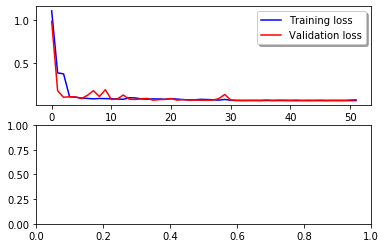

In [47]:
_epochs=100

def step_decay(epoch):
    x = 1e-3
    if epoch >= 30: x = 1e-4
    return x
lr_decay = LearningRateScheduler(step_decay)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=20, verbose=0, mode='auto')
# train the model
history = model.fit(valid_train_X, valid_train_y, 
                    validation_data=(valid_test_X, valid_test_y),
                    #callbacks=[early_stopping],
                    callbacks=[early_stopping, lr_decay],
                    epochs=_epochs, batch_size=8, verbose = 2)

              
drawResultCurves(history)

In [ ]:
print(valid_train_X.head())

In [55]:
# predict results with trained parameters
preds = model.predict(df_test.values)
pred_test_all_y = np.exp(preds)
pred_test_all_y = np.exp(preds * max_price)
print(preds)
df_test.loc[:, "revenue"] = pred_test_all_y


[[0.6811833 ]
 [0.6054496 ]
 [0.6466611 ]
 ...
 [0.71903867]
 [0.72522753]
 [0.6189291 ]]


In [48]:
print(df_test.head())

         budget  popularity   runtime  release_date_year  inCollection  \
id                                                                       
3001   0.000000    1.348472  4.499810               2007             1   
3002  11.385103    1.269701  4.174387               1958             0   
3003   0.000000    2.090034  4.605170               1997             0   
3004  15.732433    2.151298  4.867534               2010             0   
3005  14.508658    1.168661  4.521789               2005             0   

      genres_len  genres_Action  genres_Adventure  genres_Animation  \
id                                                                    
3001           4              0                 1                 1   
3002           2              0                 0                 0   
3003           2              0                 0                 0   
3004           3              0                 0                 0   
3005           2              0                 0      

In [56]:
submission_Price = pd.DataFrame({
            "id": df_test.index,
            "revenue": np.nan
        }, index=df_test.index)
        
               
submission_Price.loc[df_test.index, "revenue"] = df_test["revenue"]

submission_Price.to_csv('submission.csv', index=False)


submission_Price

,id,revenue
id,,
3001,3001,30479326.0
3002,3002,4486800.5
3003,3003,12726775.0
3004,3004,8129925.0
3005,3005,7736417.0
...,...,...
7394,7394,59631820.0
7395,7395,417888480.0
7396,7396,79417056.0


In [ ]:
""" EXPLAINABILITY """

In [49]:
# package importation
import lime.lime_tabular
import shap

In [50]:
# data preparation
# data preparation
#print(pred_test_all_y)
for layer in model.layers:
    print(layer.output_shape)
print(model.summary())

(None, 340)
(None, 120)
(None, 80)
(None, 40)
(None, 20)
(None, 20)
(None, 1)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1_input (InputLayer)   (None, 340)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               40920     
_________________________________________________________________
dense_2 (Dense)              (None, 80)                9680      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_5 (Dense)              (None, 20)                420       
_______________________________________________

In [72]:
# LIME explainer
#categorial features
#print(valid_train_X.columns)

categorical_features = []
for feature in valid_train_X.columns:
    if len(valid_train_X[feature].unique()) < 10:
        categorical_features.append(feature)
        
def predict(qc):
    global model
    qc = model.predict(qc)
    return qc.reshape(qc.shape[0])

explainer = lime.lime_tabular.LimeTabularExplainer(valid_train_X.values, 
                                                   feature_names = valid_train_X.columns.values.tolist(),
                                                   categorical_features = categorical_features,
                                                   class_names = ["revenue"],
                                                   verbose=True,
                                                   mode = "regression")

#print(valid_test_X.shape)
#print(df_test["revenue"][0:5])
print(valid_test_y)

id
752     0.733065
843     0.506807
1532    0.753460
2445    0.531700
1833    0.687921
          ...   
1961    0.723339
2717    0.427377
1420    0.552643
1994    0.606185
2333    0.459571
Name: revenue, Length: 600, dtype: float64


In [76]:
exp = explainer.explain_instance(valid_test_X.iloc[112,:], predict, num_features=5) #df_test
exp.show_in_notebook(show_table=True)
exp.as_list()

Intercept 0.6646574322543604
Prediction_local [0.64920594]
Right: 0.6333687
